In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=4)

In [4]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [5]:
client

Client Scheduler: tcp://127.0.0.1:44074 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


In [88]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp8_m1a1_4km_500a1000j/'

In [89]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

In [90]:
V = ['u_a', 'v_a']#,'ssh'
dij = 1
dti = 1
ds_a = (r['his'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds_a.nbytes/1e9))

dataset size: 2 GB


In [73]:
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [91]:
for V in ['u','v']:
    ds_a[V+'_a'] = x2rho(ds_a[V+'_a'],r.xgrid,'extrapolate')

In [92]:
ds_a = ds_a.persist()

In [93]:
KE_a = np.sqrt((ds_a.u_a-ds_a.u_a.mean(['time','x_rho']))**2+(ds_a.v_a-ds_a.v_a.mean(['time','x_rho']))**2).mean(['time','x_rho']).compute()
U_a = np.sqrt((ds_a.u_a-ds_a.u_a.mean(['time','x_rho']))**2).mean(['time','x_rho']).compute()
V_a = np.sqrt((ds_a.v_a-ds_a.v_a.mean(['time','x_rho']))**2).mean(['time','x_rho']).compute()

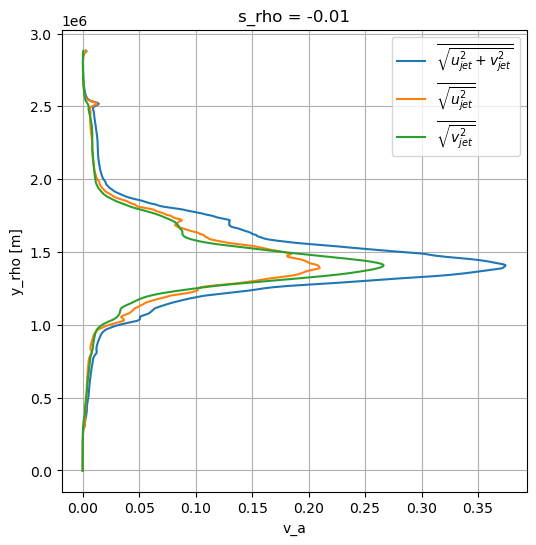

In [68]:
fig,ax = plt.subplots(figsize=(6,6))
KE_a.isel(s_rho=-1).plot(y='y_rho',label=r'$\overline{\sqrt{u_{jet}^2+v_{jet}^2}}$',ax=ax)
U_a.isel(s_rho=-1).plot(y='y_rho',label=r'$\overline{\sqrt{u_{jet}^2}}$',ax=ax)
V_a.isel(s_rho=-1).plot(y='y_rho',label=r'$\overline{\sqrt{v_{jet}^2}}$',ax=ax)
ax.grid();ax.legend()

In [94]:
path = root_path+run+'diagnostics/' #datarmor

In [95]:
corrE = {}
removed = ['avg1d']#,'total']
for name,data in zip(removed,['ZC_Eulerian_corr_80avg1d.nc']):#,'ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv','vu']:#
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

In [96]:
corrL = {}
removed = ['avg1d']#,'total']
for name,data in zip(removed,
                     ['ZC_drifters_corr_80avg1d.nc']):#,'ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

In [16]:
def fit_v2(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0)),
                     'error' : (['ybin','param'],np.expand_dims(np.sqrt(np.diag(cov)),axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [17]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt,Xt_ns,Xt_s):
    return (Xt_s+Xt_ns*np.exp(-t/Tt))*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Xb,Om):
    return Xb*np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
def Cbar_E(t,Tb,Xb):
    return Xb*np.exp(-t/Tb)#*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xt_ns,Xt_s,Tb,Xb,Omega):
    return Cbar(t,Tb,Xb,Omega)+Ctilde(t,Tt,Xt_ns,Xt_s)
def C_E(t,Tt,Xt_ns,Xt_s,Tb,Xb):
    return Cbar_E(t,Tb,Xb)+Ctilde(t,Tt,Xt_ns,Xt_s)
def fit_omega(tau,Tt,Vt_ns,Vt_s,Tb,Vb):
    return (Vt_s+Vt_ns*np.exp(-tau/Tt))*np.cos(2*np.pi*om*tau)+Vb*np.exp(-tau/Tb)

In [98]:
from inspect import signature
import scipy


# Parameters
myfunc = C #function to use for the fit
bounds = ((1,0,0,2s,0,0),(40,np.inf,np.inf,2000,np.inf,1)) # bounds for the fit to avoid non physical results
bounds_omega = ((1,0,0,2,0),(40,np.inf,np.inf,2000,np.inf))
ce,cl = 'lightseagreen','firebrick'

In [99]:
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit_v2(corrL['avg1d'][V].lag,
                                      corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit_v2(corrE['avg1d'][V].lag,
                                      corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})
    out_combE_avg[V+'_normalized'] = out_combE_avg[V].fitted/out_combE_avg[V].fitted.sel(lags=0)
    out_combL_avg[V+'_normalized'] = out_combL_avg[V].fitted/out_combL_avg[V].fitted.sel(lags=0)

In [100]:
myfunc = fit_omega
#bounds = ((1,0,0,0,0),(40,np.inf,np.inf,2000,np.inf)) # bounds for the fit to avoid non physical results
ce,cl = 'lightseagreen','firebrick'

out_combL_avg_omega,out_combE_avg_omega = {},{}
for V in ['uu','vv'] :
    out_combL_avg_omega[V] = xr.concat([fit_v2(corrL['avg1d'][V].lag,
                                      corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds_omega,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg_omega[V] = xr.concat([fit_v2(corrE['avg1d'][V].lag,
                                      corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds_omega,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

    out_combE_avg_omega[V] = out_combE_avg_omega[V].assign_coords({'ybin':out_combE_avg_omega[V].ybin.values*1e-3})
    out_combE_avg_omega[V+'_normalized'] = out_combE_avg_omega[V].fitted/out_combE_avg_omega[V].fitted.sel(lags=0)
    out_combL_avg_omega[V+'_normalized'] = out_combL_avg_omega[V].fitted/out_combL_avg_omega[V].fitted.sel(lags=0)

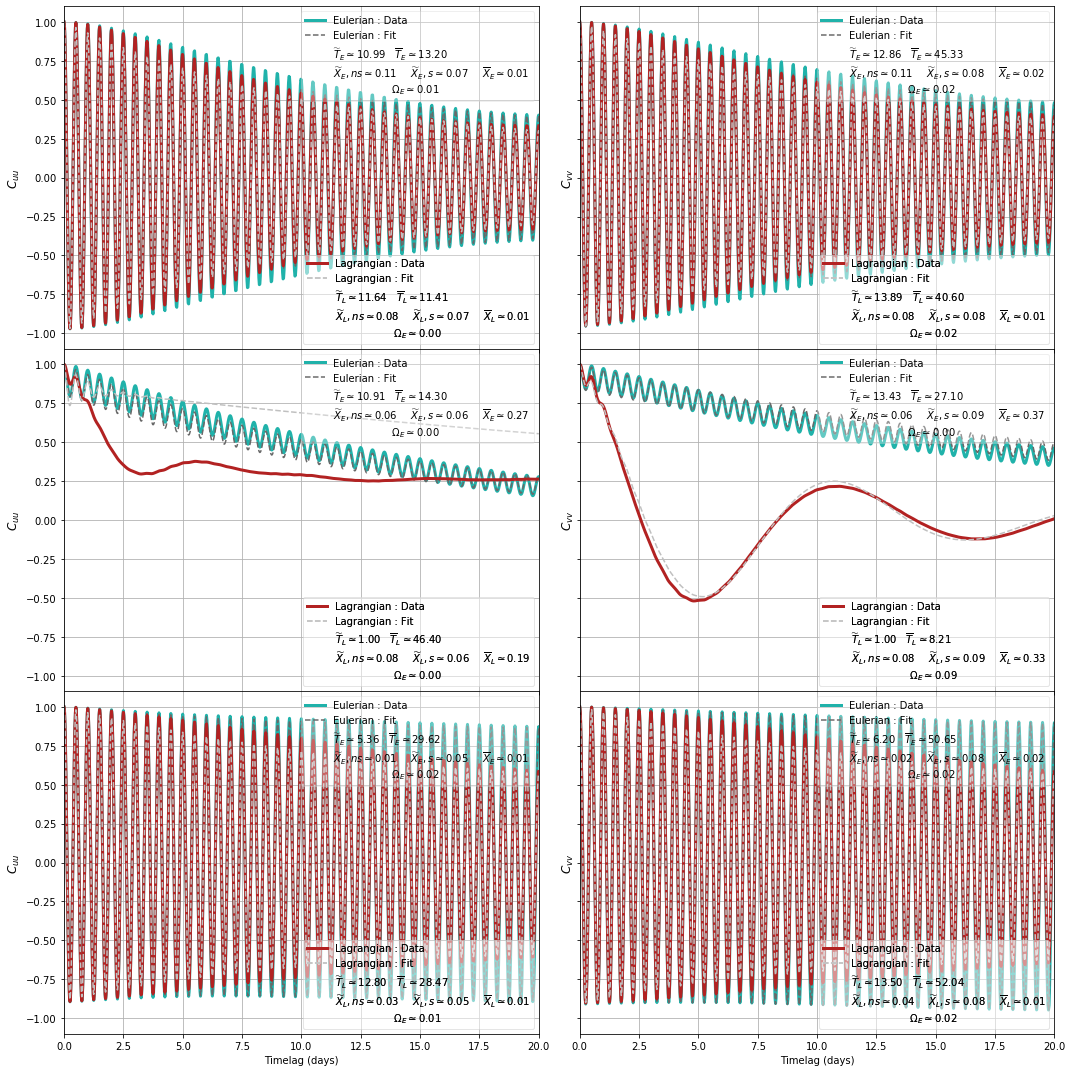

In [30]:
import matplotlib as mpl
from matplotlib.patches import Rectangle

ce_fit = 'dimgrey'
cl_fit='silver'
#Sections
Y=[2300,1425,700]

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

# place a text box in upper left in axes coords


fig,axs = plt.subplots(3,2,figsize=(15,15),sharex=True, sharey=True,gridspec_kw={'hspace': 0})
for i,y in enumerate(Y):
    for V,ax in zip(['uu','vv'],axs[i,:]):
        paE = out_combE_avg[V].sel(ybin=y,method='nearest').params.values
        paL = out_combL_avg[V].sel(ybin=y,method='nearest').params.values
        textstrE = '\n'.join((
            r'$\widetilde{T}_E\simeq%.2f\hspace{1}\overline{T}_E\simeq%.2f$' % (paE[0], paE[3]),
            r'$\widetilde{X}_E,ns\simeq%.2f\hspace{1.5}\widetilde{X}_E,s\simeq%.2f\hspace{1.5}\overline{X}_E\simeq%.2f$' % (np.sqrt(paE[1]),np.sqrt(paE[2]),np.sqrt(paE[4])),
            r'$\hspace{6}\Omega_E\simeq%.2f$'% (paE[5],)
                            ))
        textstrL = '\n'.join((
            r'$\widetilde{T}_L\simeq%.2f\hspace{1}\overline{T}_L\simeq%.2f$' % (paL[0], paL[3]),
            r'$\widetilde{X}_L,ns\simeq%.2f\hspace{1.5}\widetilde{X}_L,s\simeq%.2f\hspace{1.5}\overline{X}_L\simeq%.2f$' % (np.sqrt(paL[1]),np.sqrt(paE[2]),np.sqrt(paL[4])),
            r'$\hspace{6}\Omega_E\simeq%.2f$'% (paL[5],)
                            ))
        corrE['avg1d'][V+'_normalized'].sel(y_bins=y*1e3,method='nearest').plot(c=ce,linewidth = 3,ax=ax,label=('Eulerian : Data'))
        out_combE_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(c = ce_fit,linestyle='--',ax=ax,label=('Eulerian : Fit'))
        corrL['avg1d'][V+'_normalized'].sel(y_bins=y,method='nearest').plot(c=cl,linewidth = 3,ax=ax,label=('Lagrangian : Data'))
        out_combL_avg[V+'_normalized'].sel(ybin=y,method='nearest').plot(c=cl_fit,linestyle='--',ax=ax,label=('Lagrangian : Fit'))
        handles,labels = ax.get_legend_handles_labels()
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        legendE = ax.legend(handles[:2]+[extra],labels[:2]+[textstrE],loc='upper right',framealpha=0.3);
        ax.add_artist(legendE)
        legendL = ax.legend(handles[2:]+[extra],labels[2:]+[textstrL],loc='lower right',framealpha=0.3)
        ax.add_artist(legendL)
        ax.set_ylim(-1.1,1.1);ax.grid();ax.set_title('')
        ax.set_ylabel(r'$C_{%s}$'%V,fontsize=12);ax.set_xlabel('Timelag (days)')
        ax.set_xlim(0,20)
    fig.tight_layout()
#fig.savefig('/home1/datawork/zcaspar/Fig_paper/sections_fit_20v2.pdf')

In [101]:
lims_uu = [(0,40),(0,40),(-0.01,0.05),(0,0.2),(0,0.2),(0,0.4)]
lims_vv = [(0,40),(0,40),(-0.01,0.05),(0,0.2),(0,0.2),(0,0.4)]
titles = [r'$\widetilde{T}$',r'$\overline{T}$',r'$\Omega$',r'$\widetilde{X}_{ns}$',r'$\widetilde{X}_s$',r'$\overline{X}$']

Text(0.5, 0.98, 'Autocorrelation of u')

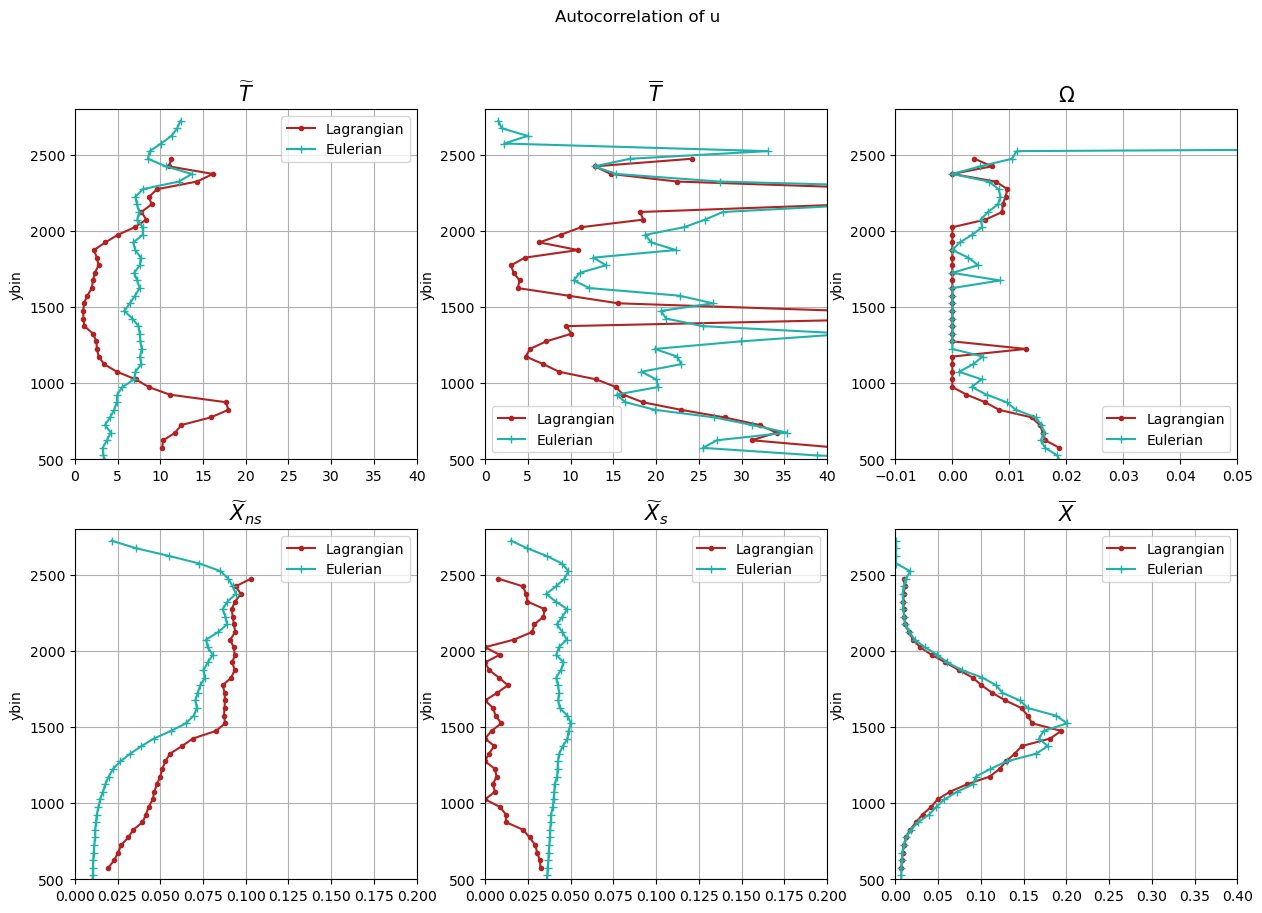

In [102]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb','Omega'],titles[:3],lims_uu[:3],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Xt_ns','Xt_s','Xb'],titles[3:],lims_uu[3:],axes[1,:]):
    np.sqrt(out_combL_avg['uu'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(out_combE_avg['uu'].params.sel(param=pa)).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of u')


Text(0.5, 0.98, 'Autocorrelation of v')

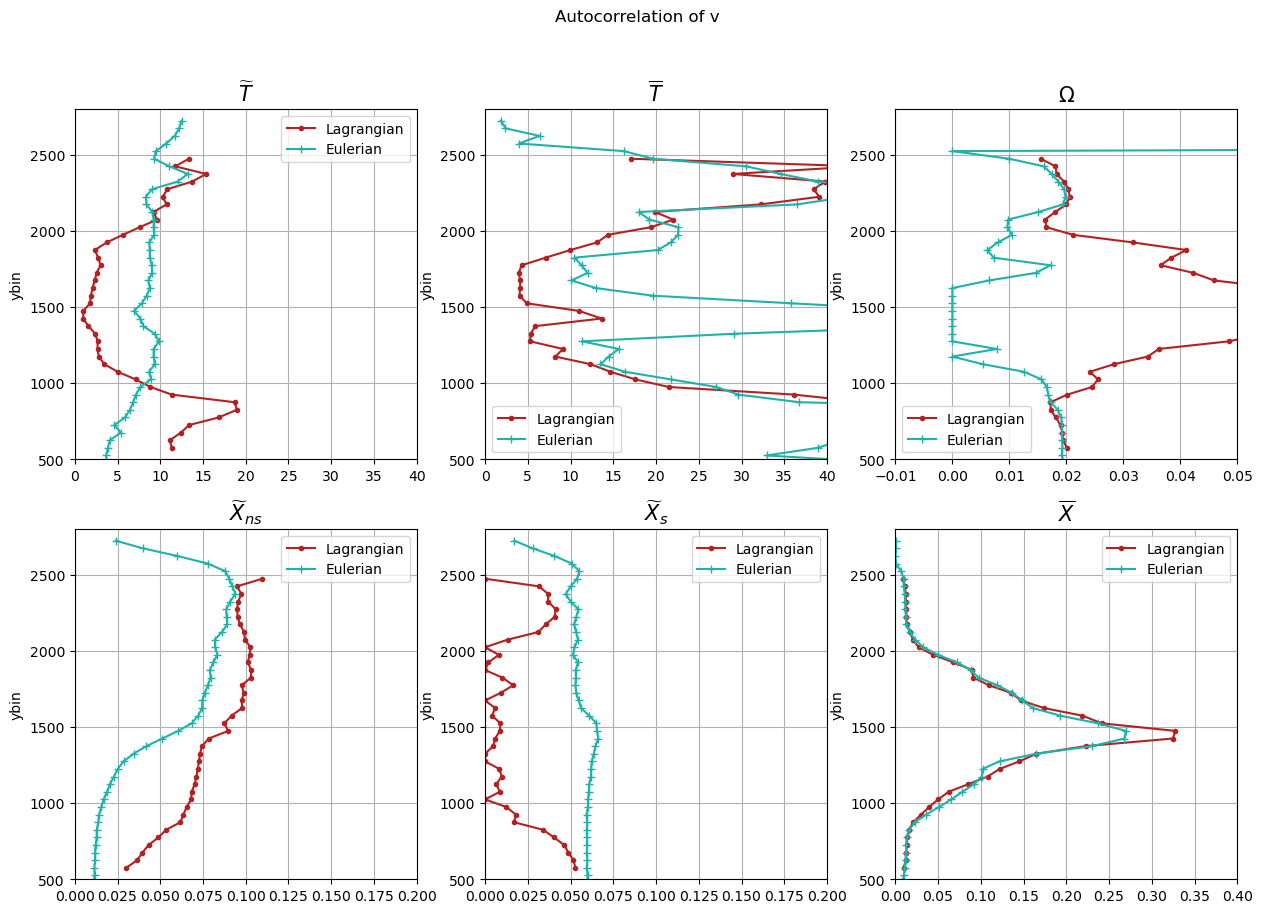

In [103]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb','Omega'],titles[:3],lims_vv[:3],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Xt_ns','Xt_s','Xb'],titles[3:],lims_vv[3:],axes[1,:]):
    np.sqrt(out_combL_avg['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(out_combE_avg['vv'].params.sel(param=pa)).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of v')
#fig.savefig('/home1/datawork/zcaspar/Fig_paper/params_fit_v2.pdf')

Text(0.5, 0.98, 'Autocorrelation of v')

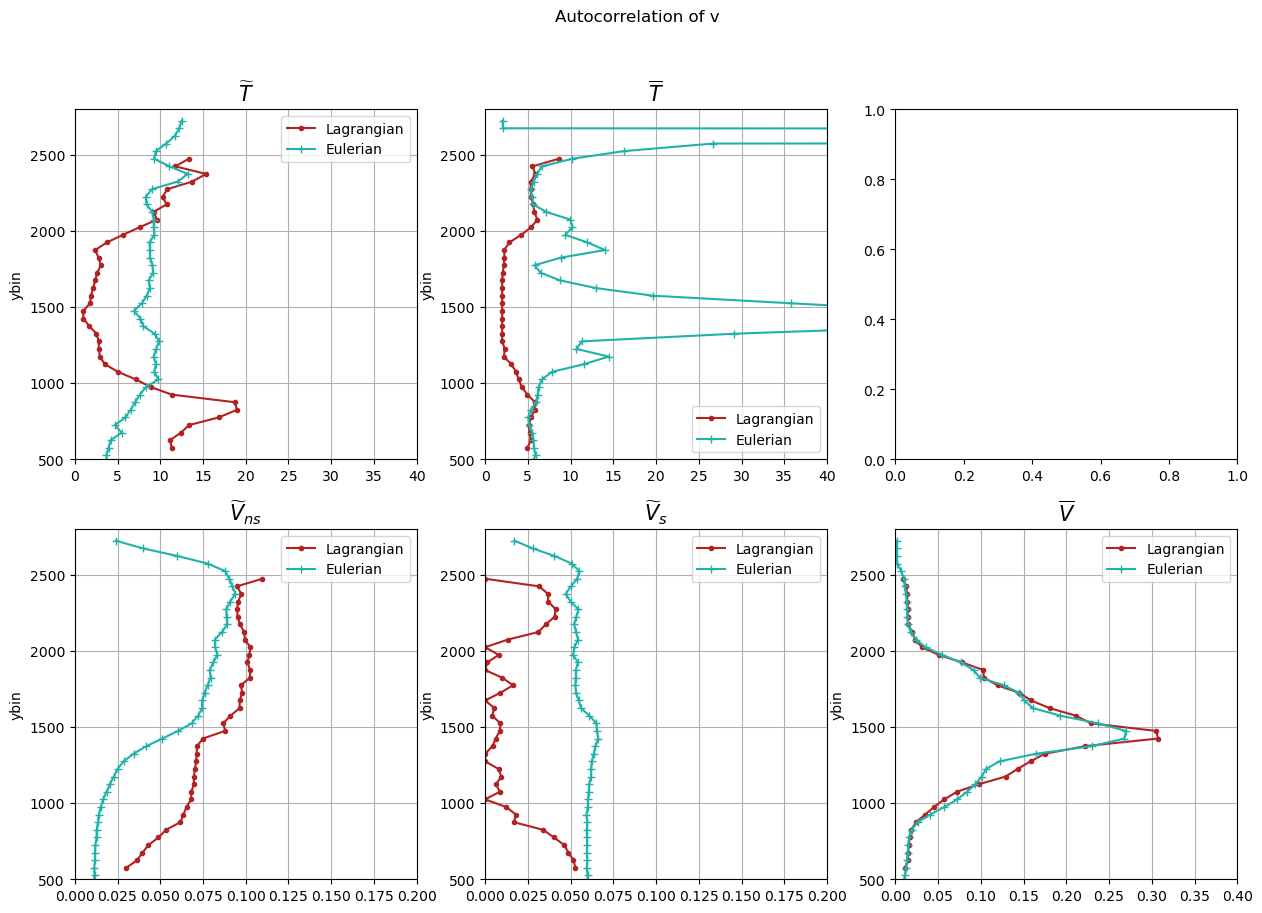

In [104]:
lims_uu = [(0,40),(0,40),(0,0.2),(0,0.2),(0,0.4)]
lims_vv = [(0,40),(0,40),(0,0.2),(0,0.2),(0,0.4)]
titles = [r'$\widetilde{T}$',r'$\overline{T}$',r'$\widetilde{V}_{ns}$',r'$\widetilde{V}_s$',r'$\overline{V}$']

fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg_omega['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg_omega['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt_ns','Vt_s','Vb'],titles[2:],lims_vv[2:],axes[1,:]):
    np.sqrt(out_combL_avg_omega['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(out_combE_avg_omega['vv'].params.sel(param=pa)).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of v')

Text(0.5, 0.98, 'Autocorrelation of v')

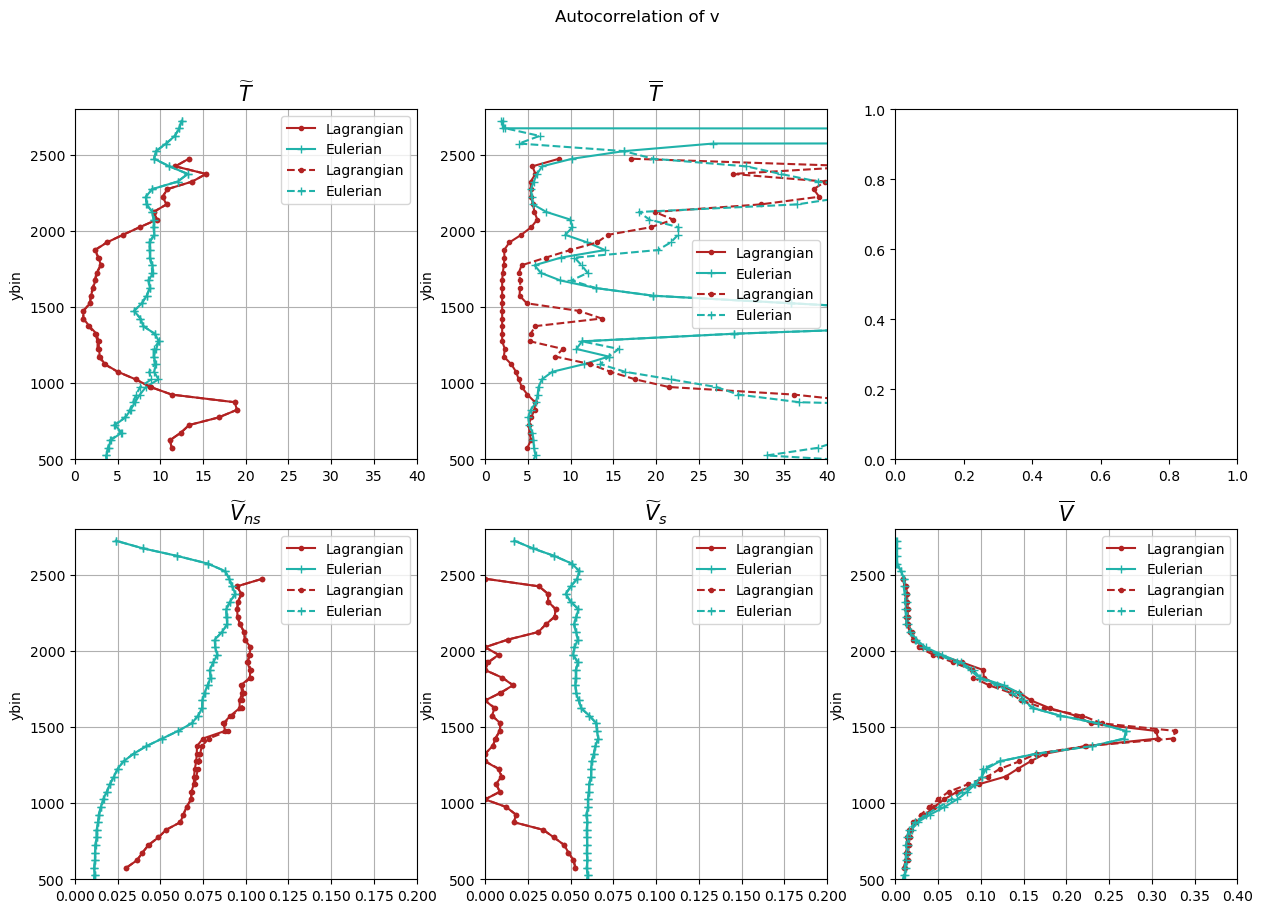

In [105]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims_vv[:2],axes[0,:]):
    out_combL_avg_omega['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    out_combE_avg_omega['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',label='Eulerian')
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c=cl,ax=ax,marker='.',linestyle='--',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c=ce,ax=ax,marker='+',linestyle='--',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Vt_ns','Vt_s','Vb'],titles[2:],lims_vv[2:],axes[1,:]):
    np.sqrt(out_combL_avg_omega['vv'].params.sel(param=pa)).plot(y='ybin',c=cl,ax=ax,marker='.',label='Lagrangian')
    np.sqrt(out_combE_avg_omega['vv'].params.sel(param=pa)).plot(y='ybin', c=ce,ax=ax,marker='+',label='Eulerian')
    np.sqrt(out_combL_avg['vv'].params.sel(param='X'+pa[1:])).plot(y='ybin',c=cl,ax=ax,marker='.',linestyle='--',label='Lagrangian')
    np.sqrt(out_combE_avg['vv'].params.sel(param='X'+pa[1:])).plot(y='ybin', c=ce,ax=ax,marker='+',linestyle='--',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.suptitle('Autocorrelation of v')

In [106]:
vmodes = xr.open_dataset(path+'ZC_waves_modes.nc').persist()

In [107]:
Lt = vmodes.lwave.sel(mode=1)
Lt = Lt.assign_coords({'y_bins' : Lt.y_rho*1e-3})
#Ubar = ds_a.KE.isel(s_rho=-1).mean(['time','x_rho']).compute()
#Ubar = Ubar.assign_coords({'y_bins' : Ubar.y_rho*1e-3})
#Urms = np.sqrt(ds_a['Mean'].isel(s_rho=-1)).compute()
#Urms = Urms.assign_coords({'y_bins' : Urms.y_rho*1e-3})
Uprms = np.sqrt(((ds_a.u_a-ds_a.u_a.mean(['time','x_rho']))**2+(ds_a.v_a-ds_a.v_a.mean(['time','x_rho']))**2)
                .mean(['time','x_rho']).isel(s_rho=-1)).compute()
Uprms = Uprms.assign_coords({'y_bins' : Uprms.y_rho*1e-3})
Uprime = np.sqrt((ds_a.u_a-ds_a.u_a.mean(['time','x_rho']))**2+(ds_a.v_a-ds_a.v_a.mean(['time','x_rho']))**2).mean(['time','x_rho']).isel(s_rho=-1).compute()
Uprime = Uprime.assign_coords({'y_bins' : Uprime.y_rho*1e-3})

Lt_Uprime = Lt*1e3/Uprime/(24*3600)
Lt_Uprms = Lt*1e3/Uprms/(24*3600)
Lt_U = Lt*1e3/U_a/(24*3600)
Lt_V = Lt*1e3/V_a/(24*3600)

Lt_Uprime.name = 'LtUprime'
Lt_Uprms.name = 'LtUprms'
Lt_U.name = 'LtU'
Lt_V.name = 'LtV'

In [108]:
Lt_Uprime_mean = Lt_Uprime.groupby_bins('y_bins',out_combE_avg_omega['uu'].ybin+25,include_lowest=False).mean()
Lt_Uprms_mean = Lt_Uprms.groupby_bins('y_bins',out_combE_avg_omega['uu'].ybin+25,include_lowest=False).mean()
Lt_U_mean = Lt_U.groupby_bins('y_bins',out_combE_avg_omega['uu'].ybin+25,include_lowest=False).mean()
Lt_V_mean = Lt_V.groupby_bins('y_bins',out_combE_avg_omega['uu'].ybin+25,include_lowest=False).mean()

Lt_Uprime_mean = Lt_Uprime_mean.assign_coords({'y_bins_bins':[yy.mid for yy in Lt_Uprime_mean.y_bins_bins.values]}).rename({'y_bins_bins':'ybin'})
Lt_Uprms_mean = Lt_Uprms_mean.assign_coords({'y_bins_bins':[yy.mid for yy in Lt_Uprms_mean.y_bins_bins.values]}).rename({'y_bins_bins':'ybin'})
Lt_U_mean = Lt_U_mean.assign_coords({'y_bins_bins':[yy.mid for yy in Lt_U_mean.y_bins_bins.values]}).rename({'y_bins_bins':'ybin'})

Lt_V_mean = Lt_V_mean.assign_coords({'y_bins_bins':[yy.mid for yy in Lt_V_mean.y_bins_bins.values]}).rename({'y_bins_bins':'ybin'})

In [72]:
DS_avg = xr.Dataset(data_vars={'Ta' : Lt_Uprime_mean,'Ta_u' : Lt_U_mean,'Ta_v' : Lt_V_mean,'Ta_rms' : Lt_Uprms_mean,
                               'E_u_avg': out_combE_avg['uu'].params,
                               'L_u_avg' : out_combL_avg['uu'].params,
                               'E_v_avg' : out_combE_avg['vv'].params,
                               'L_v_avg' : out_combL_avg['vv'].params,
                               'E_u_error': out_combE_avg['uu'].error,
                               'L_u_error' : out_combL_avg['uu'].error,
                               'E_v_error' : out_combE_avg['vv'].error,
                               'L_v_error' : out_combL_avg['vv'].error,
                              'Uprime' : Uprime,'Urms':Uprms,'U' : U_a,'V' : V_a
                          })

In [109]:
DS_avg = xr.Dataset(data_vars={'Ta' : Lt_Uprime_mean,'Ta_u' : Lt_U_mean,'Ta_v' : Lt_V_mean,'Ta_rms' : Lt_Uprms_mean,
                               'E_u_avg': out_combE_avg_omega['uu'].params,
                               'L_u_avg' : out_combL_avg_omega['uu'].params,
                               'E_v_avg' : out_combE_avg_omega['vv'].params,
                               'L_v_avg' : out_combL_avg_omega['vv'].params,
                               'E_u_error': out_combE_avg_omega['uu'].error,
                               'L_u_error' : out_combL_avg_omega['uu'].error,
                               'E_v_error' : out_combE_avg_omega['vv'].error,
                               'L_v_error' : out_combL_avg_omega['vv'].error,
                              'Uprime' : Uprime,'Urms':Uprms,'U' : U_a,'V' : V_a
                          })

In [110]:
r.store_diagnostic('ZC_param_fit_T80_v2_omega', DS_avg, overwrite=True,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/jet_cfg1_wp8_m1a1_4km_500a1000j/diagnostics/ZC_param_fit_T80_v2_omega.nc


In [111]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
